In [6]:
import os
os.getcwd()

#os.chdir("kaggle/hubmap")

'/content'

In [2]:
os.listdir("../content/drive/kaggle")

NameError: ignored

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from PIL import Image
im = Image.open('a_image.tif')

In [4]:
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import cv2

#!pip install tifffile
import tifffile

In [7]:
BASE_PATH = "/content/drive/MyDrive/kaggle/hubmap" #"d:/kaggle/hubmap/"
TRAIN_PATH = BASE_PATH#os.path.join(BASE_PATH, "train")

print(os.listdir(BASE_PATH))
df_train = pd.read_csv(
    os.path.join(BASE_PATH, "train.csv")
)
df_train

['aaa6a05cc.tiff', 'train.csv', 'aaa6a05cc.json', 'aaa6a05cc-anatomical-structure.json', 'sample_submission.csv', 'HuBMAP-20-dataset_information.csv', 'img_segaaa6a05cc.pickle', 'img_segaaa6a05cc.npz']


,id,encoding
0,2f6ecfcdf,296084587 4 296115835 6 296115859 14 296147109...
1,aaa6a05cc,30989109 59 31007591 64 31026074 68 31044556 7...
2,cb2d976f4,78144363 5 78179297 15 78214231 25 78249165 35...
3,0486052bb,101676003 6 101701785 8 101727568 9 101753351 ...
4,e79de561c,8273094 14 8289273 41 8305453 67 8321632 82 83...
5,095bf7a1f,113430380 22 113468538 67 113506697 111 113544...
6,54f2eec69,124601765 36 124632133 109 124662536 147 12469...
7,1e2425f28,49453112 7 49479881 22 49506657 31 49533433 40...


In [28]:
df_sub = pd.read_csv(
    os.path.join(BASE_PATH, "sample_submission.csv"))
df_sub

,id,predicted
0,b9a3865fc,NaN
1,b2dc8411c,NaN
2,26dc41664,NaN
3,c68fe75ea,NaN
4,afa5e8098,NaN


In [8]:
print(f"Number of train images: {df_train.shape[0]}")
print(f"Number of test images: {df_sub.shape[0]}")

Number of train images: 8


NameError: ignored

In [9]:
df_info = pd.read_csv(
    os.path.join(BASE_PATH, "HuBMAP-20-dataset_information.csv")
)
df_info.sample(3)

,image_file,width_pixels,height_pixels,anatomical_structures_segmention_file,glomerulus_segmentation_file,patient_number,race,ethnicity,sex,age,weight_kilograms,height_centimeters,bmi_kg/m^2,laterality,percent_cortex,percent_medulla
3,e79de561c.tiff,27020,16180,e79de561c-anatomical-structure.json,e79de561c.json,67026,Black or African American,Not Hispanic or Latino,Male,53,73.0,166.0,26.5,Left,55,45
8,b9a3865fc.tiff,40429,31295,b9a3865fc-anatomical-structure.json,b9a3865fc.json,67347,White,Not Hispanic or Latino,Female,58,59.0,160.0,23.0,Right,55,45
1,54f2eec69.tiff,22240,30440,54f2eec69-anatomical-structure.json,54f2eec69.json,67548,Black or African American,Not Hispanic or Latino,Male,58,79.9,190.5,22.0,Right,75,25


In [ ]:
def rle2mask(rle, width, height):
    if rle == '-1':
        return np.zeros((width, height))
    mask = np.zeros(width * height)
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        current_position += start
        mask[current_position:current_position+lengths[index]] = 255
        current_position += lengths[index]

    return mask.reshape(width, height)

In [ ]:
def rle2mask(rle, height, width):
    rle        = [int(xx) for xx in rle.split(' ')]
    offsets, runs = rle[0::2], rle[1::2]
    
    tmp = np.zeros(height * width, dtype=np.uint8)
    for offset, run in zip(offsets, runs):
        tmp[offset:offset + run] = 1
    
    return tmp.reshape(width, height).T

In [ ]:
def rle2mask(rle, imgshape):
    width = imgshape[0]
    height= imgshape[1]
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return np.flipud( np.rot90( mask.reshape(height,width), k=1 ) )

In [10]:
# https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode
    
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)
 
def rle2mask(mask_rle, shape=(1600,256)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

def countplot(column, plot_type='multiple', gridstyle='whitegrid', gs=None,
              palette='Accent', xlab=None, ylab=None, title=None, fontsize=12):
    
    '''
    Make countplots
    -----------------
    
    Arguments:
    column -- column with categorical values
    plot_type -- multiple grid ('multiple/single')
    gridstyle -- seaborn gridstyle
    gs -- gridspec (if using subplots)
    palette -- color palette
    xlab -- x-axis label
    ylab -- y-axois label
    title -- plot title
    fontsize -- fontsize
    
    Returns:
    sns.countplot()
    '''
    if plot_type=='multiple':
        with sns.axes_style(gridstyle):
            ax = f.add_subplot(gs)
            aa = sns.countplot(column, palette=palette)
            for p in ax.patches:
                height = p.get_height()
                aa.text(p.get_x()+p.get_width()/2.,
                        height,
                        '{:1.2f}%'.format(height/len(column)*100),
                        ha="center", fontsize=fontsize)
            plt.xlabel(xlab,fontsize=fontsize)
            plt.ylabel(ylab,fontsize=fontsize)
            plt.title(title)
            
    elif plot_type=='single':
        with sns.axes_style("whitegrid"):
            aa = sns.countplot(column, palette=palette)
            for p in aa.patches:
                height = p.get_height()
                aa.text(p.get_x()+p.get_width()/2.,
                        height,
                        '{:1.2f}%'.format(height/len(column)*100),
                        ha="center", fontsize=fontsize)
            plt.xlabel(xlab,fontsize=fontsize)
            plt.ylabel(ylab,fontsize=fontsize)
            plt.title(title)

In [11]:
image_id = "aaa6a05cc"

image = tifffile.imread(
    #os.path.join(BASE_PATH, f"train/{image_id}.tiff")
    os.path.join(BASE_PATH,f"{image_id}.tiff")
)

mask = rle2mask(
    df_train[df_train["id"] == image_id]["encoding"].values[0], 
    (image.shape[1], image.shape[0])
)

print(f"Image shape: {image.shape}")
print(f"Mask shape: {mask.shape}")

Image shape: (18484, 13013, 3)
Mask shape: (18484, 13013)


In [12]:
BASE_PATH
os.path.join(BASE_PATH,"{}.tiff".format(image_id))
#os.path.join(BASE_PATH, "train.csv")

'/content/drive/MyDrive/kaggle/hubmap/aaa6a05cc.tiff'

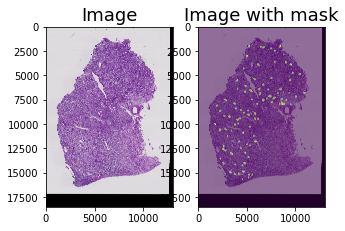

In [13]:
plt.figure(figsize=(5, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Image", fontsize=18)
plt.subplot(1, 2, 2)
plt.imshow(image)
plt.imshow(mask, alpha=0.5)
plt.title("Image with mask", fontsize=18);

In [33]:
df_train[df_train["id"] == image_id]["encoding"].values[0]

'30989109 59 31007591 64 31026074 68 31044556 72 31063039 76 31081522 80 31100004 85 31118487 89 31136969 93 31155452 97 31173934 102 31192417 106 31210900 110 31229382 115 31247865 119 31266347 123 31284830 127 31303313 131 31321795 136 31340277 141 31358761 144 31377245 147 31395729 149 31414213 152 31432696 156 31451180 158 31469664 159 31488148 160 31506632 161 31525116 163 31543600 165 31562083 168 31580567 169 31599051 170 31617535 171 31636019 171 31654503 172 31672987 173 31691471 174 31709954 176 31728438 177 31746922 178 31765406 179 31783890 180 31802374 181 31820858 183 31839341 185 31857825 186 31876309 187 31894793 188 31913277 189 31931761 190 31950245 191 31968728 193 31987212 194 32005696 195 32024180 196 32042664 197 32061148 198 32079632 200 32098116 201 32116599 203 32135083 204 32153567 205 32172051 206 32190535 207 32209019 208 32227503 208 32245986 210 32264470 210 32282954 211 32301438 211 32319922 212 32338406 212 32356890 213 32375373 214 32393857 215 32412341

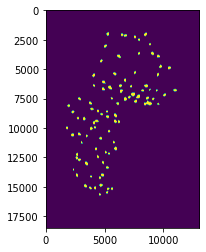

In [15]:
plt.imshow(mask)

In [16]:
# basic
import os, gc
import warnings
import numpy as np
import pandas as pd

# visualize
import seaborn as sns
import matplotlib.pyplot as plt

# reading tiff images
import tifffile as tiff 

%matplotlib inline

warnings.filterwarnings('ignore')

# directory
print('Competition Data/Files')
ROOT = '.'
os.listdir(ROOT)

Competition Data/Files


['.config', 'drive', 'sample_data']

In [18]:
gc.collect()

4547

In [17]:
train = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
train.head()
    

,id,encoding
0,2f6ecfcdf,296084587 4 296115835 6 296115859 14 296147109...
1,aaa6a05cc,30989109 59 31007591 64 31026074 68 31044556 7...
2,cb2d976f4,78144363 5 78179297 15 78214231 25 78249165 35...
3,0486052bb,101676003 6 101701785 8 101727568 9 101753351 ...
4,e79de561c,8273094 14 8289273 41 8305453 67 8321632 82 83...


In [ ]:
print(f'Missing values in train.csv in each columns:\n{train.isnull().sum()}')

Missing values in train.csv in each columns:
id          0
encoding    0
dtype: int64


In [ ]:
print('Unique Values in each column of train.csv')
print('##########################################')
for col in train:
    print(f'{col}: {train[col].nunique()}')

Unique Values in each column of train.csv
##########################################
id: 8
encoding: 8


In [19]:
metadata = pd.read_csv(os.path.join(BASE_PATH, 'HuBMAP-20-dataset_information.csv'))
metadata.head()

,image_file,width_pixels,height_pixels,anatomical_structures_segmention_file,glomerulus_segmentation_file,patient_number,race,ethnicity,sex,age,weight_kilograms,height_centimeters,bmi_kg/m^2,laterality,percent_cortex,percent_medulla
0,afa5e8098.tiff,43780,36800,afa5e8098-anatomical-structure.json,afa5e8098.json,67347,White,Not Hispanic or Latino,Female,58,59.0,160.0,23.0,Right,55,45
1,54f2eec69.tiff,22240,30440,54f2eec69-anatomical-structure.json,54f2eec69.json,67548,Black or African American,Not Hispanic or Latino,Male,58,79.9,190.5,22.0,Right,75,25
2,1e2425f28.tiff,32220,26780,1e2425f28-anatomical-structure.json,1e2425f28.json,63921,White,Not Hispanic or Latino,Male,48,131.5,193.0,35.3,Right,65,35
3,e79de561c.tiff,27020,16180,e79de561c-anatomical-structure.json,e79de561c.json,67026,Black or African American,Not Hispanic or Latino,Male,53,73.0,166.0,26.5,Left,55,45
4,c68fe75ea.tiff,19780,26840,c68fe75ea-anatomical-structure.json,c68fe75ea.json,67112,White,Not Hispanic or Latino,Male,56,91.2,167.6,32.5,Left,80,20


In [20]:
print(f'We have {metadata.shape[0]} rows and {metadata.shape[1]} columns in our metadata.csv.')

We have 13 rows and 16 columns in our metadata.csv.


In [ ]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 16 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   image_file                             13 non-null     object 
 1   width_pixels                           13 non-null     int64  
 2   height_pixels                          13 non-null     int64  
 3   anatomical_structures_segmention_file  13 non-null     object 
 4   glomerulus_segmentation_file           13 non-null     object 
 5   patient_number                         13 non-null     int64  
 6   race                                   13 non-null     object 
 7   ethnicity                              13 non-null     object 
 8   sex                                    13 non-null     object 
 9   age                                    13 non-null     int64  
 10  weight_kilograms                       12 non-null     float64
 11  height_c

In [ ]:
print(f'Missing values in metadata.csv in each columns:\n{metadata.isnull().sum()}')


Missing values in metadata.csv in each columns:
image_file                               0
width_pixels                             0
height_pixels                            0
anatomical_structures_segmention_file    0
glomerulus_segmentation_file             0
patient_number                           0
race                                     0
ethnicity                                0
sex                                      0
age                                      0
weight_kilograms                         1
height_centimeters                       1
bmi_kg/m^2                               1
laterality                               0
percent_cortex                           0
percent_medulla                          0
dtype: int64


In [22]:
print('Unique Values in each column of metadata.csv')
print('##########################################')
for col in metadata:
    print(f'{col}: {metadata[col].nunique()}')

Unique Values in each column of metadata.csv
##########################################
image_file: 13
width_pixels: 13
height_pixels: 12
anatomical_structures_segmention_file: 13
glomerulus_segmentation_file: 13
patient_number: 10
race: 2
ethnicity: 1
sex: 2
age: 9
weight_kilograms: 9
height_centimeters: 7
bmi_kg/m^2: 9
laterality: 2
percent_cortex: 4
percent_medulla: 4


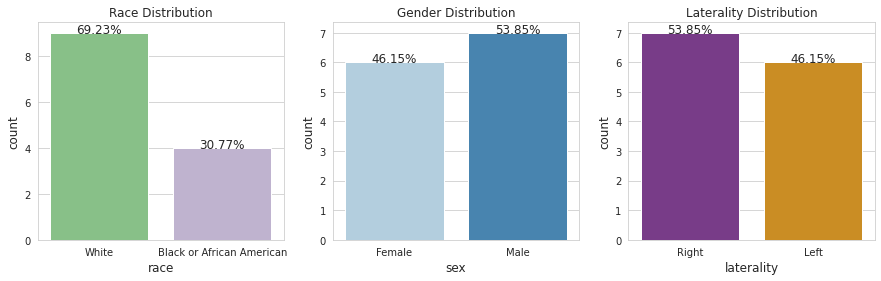

In [23]:
f = plt.figure(figsize=(15, 4))
gs = f.add_gridspec(1, 3)

countplot(metadata['race'], gs=gs[0,0], xlab='race', ylab='count', title='Race Distribution')
countplot(metadata['sex'], gs=gs[0,1], palette='Blues', xlab='sex', ylab='count', title='Gender Distribution')
countplot(metadata['laterality'], gs=gs[0,2], palette='CMRmap', xlab='laterality', ylab='count',
          title='Laterality Distribution')

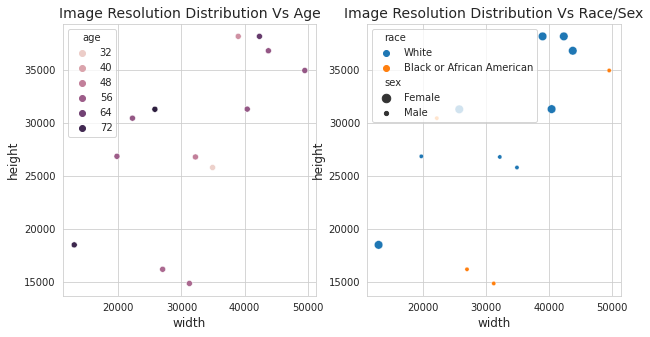

In [24]:
f = plt.figure(figsize=(10, 5))
gs = f.add_gridspec(1, 2)

with sns.axes_style("whitegrid"):
    ax = f.add_subplot(gs[0, 0])
    sns.scatterplot(metadata['width_pixels'], metadata['height_pixels'], hue=metadata['age'])
    plt.xlabel('width',fontsize=12)
    plt.ylabel('height',fontsize=12)
    plt.title('Image Resolution Distribution Vs Age', fontsize=14)
    
with sns.axes_style("whitegrid"):
    ax = f.add_subplot(gs[0, 1])
    sns.scatterplot(metadata['width_pixels'], metadata['height_pixels'], hue=metadata['race'], size=metadata['sex'])
    plt.xlabel('width',fontsize=12)
    plt.ylabel('height',fontsize=12)
    plt.title('Image Resolution Distribution Vs Race/Sex', fontsize=14)

In [ ]:
plt.figure(figsize=(100,50))
d1=np.array(range(7000,10500,1))
d2=np.array(range(1200,1700,1))
plt.imshow(image[7000:10500, 1200:5700, :])
plt.imshow(mask[7000:10500, 1200:5700], cmap='jet', alpha=0.15)


In [ ]:
plt.figure(figsize=(10,5))
d1=np.array(range(7000,10500,1))
d2=np.array(range(1200,1700,1))
plt.imshow(image[9700:10200, 1600:2100, :])
plt.imshow(mask[9700:10200, 1600:2100], cmap='jet', alpha=0.5)

In [ ]:
plt.figure(figsize=(10,5))
d1=np.array(range(7000,10500,1))
d2=np.array(range(1200,1700,1))
plt.imshow(image[10000:10500, 5150:5600, :])
plt.imshow(mask[10000:10500, 5150:5600], cmap='jet', alpha=0.515)

In [ ]:
d1

array([ 7000,  7001,  7002, ..., 10497, 10498, 10499])

#### suggestions:
- 1: segment each tiff to np.array objects, each of a given dimension, e.g. 224x224
- 2: create dataset with arrays, or images as ind. vars and whether masked as dep. var

In [ ]:


def save_load_pickle(pickfile, obj, save=True):
  import pickle
  if save:

    with open(pickfile, 'wb') as f:
        pickle.dump(obj, f) #, protocol=pickle.HIGHEST_PROTOCOL

  else:
    with open(pickfile, 'rb') as f:
        return pickle.load(f)


#ws2=save_load_pickle('WB.1.oct820.pickle',[W,B], False)
imseg=image[10000:10500, 5150:5600, :]
save_load_pickle('img_seg'+image_id+'.pickle',imseg, True)



In [41]:
im=save_load_pickle('img_seg'+image_id+'.pickle',None, False)
plt.figure(figsize=(10,5))
plt.imshow(im)



NameError: ignored

In [30]:
# storage space of 1 tiff file, if segmented into 224*224 files,
# in Gb; here,image_id = "aaa6a05cc". 
# orig tiff size = ~405 Mb

print("{} Gb for file with id = {}".format(round((660*(image.shape[0]/224)*(image.shape[1]/224))/1e6,2), image_id))
print("# of files when segmenting with 224*224 mask:{}".format(round((image.shape[0]/224)*(image.shape[1]/224)),2))
image.shape

3.16 Gb for file with id = aaa6a05cc
# of files when segmenting with 224*224 mask:4794


(18484, 13013, 3)

In [ ]:
# alternative save approach
np.savez_compressed('img_seg'+image_id, a=imseg)

# 618 Kb vs 660 Kb

In [31]:
mask_dim=224
print("{} Gb for file with id = {}".format(round((620*(image.shape[0]/mask_dim)*(image.shape[1]/mask_dim))/1e6,2), image_id))
print("# of files when segmenting with {}*{} mask:{}".format(mask_dim,mask_dim,round((image.shape[0]/mask_dim)*(image.shape[1]/mask_dim)),2))


2.97 Gb for file with id = aaa6a05cc
# of files when segmenting with 224*224 mask:4794


#### try: https://www.kaggle.com/marcosnovaes/hubmap-read-data-and-build-tfrecords
#### there, he gets for this file (suffix = 'cc') 30 dirs, each contains 25 files. Approx. size of each - ranges between 1 Kb to >600 Kb. 
#### I estimate that overall he has here:

In [ ]:
36*25*500/1e6 # Gb 


0.45

#### but it's acually 386 Mb:
![image.png](attachment:image.png)

In [ ]:
# TODO
# Try to zip the format before trying TFrecords
# actually tile the image
# utilize gpu https://www.tensorflow.org/guide/gpu

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [ ]:
tf.config.experimental.list_physical_devices('GPU')
tf.test.gpu_device_name()

''

In [ ]:
((len(l1)-1)*(len(l2)-1))
len(l2)
np.random.randint(100,510)

312

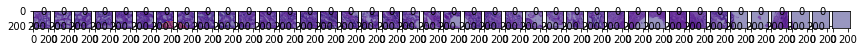

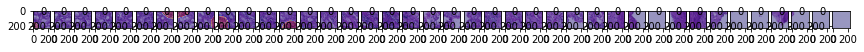

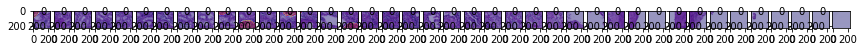

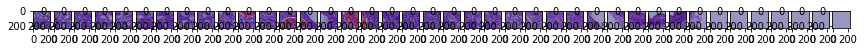

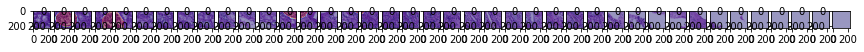

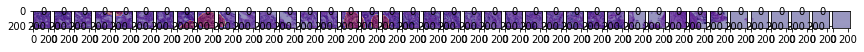

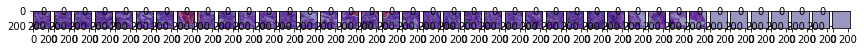

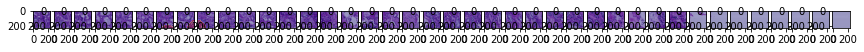

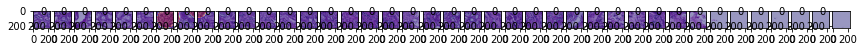

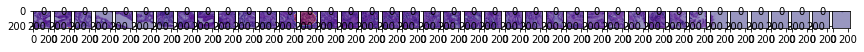

In [ ]:
import matplotlib.pyplot as plt
image.shape
l1=list(range(0,image.shape[0],224))
l2=list(range(0,image.shape[1],224))


l1=list(range(7000,10000,224))
l2=list(range(2000,11000,224))
plt.figure(figsize=(15,15))
# plt.tight_layout()

#fig, axes = plt.subplots(nrows=3, ncols=5)
#plt.subplots(nrows=3, ncols=5)
#fig.tight_layout()
#plt.subplot(1, 2, 1)
c=1
np.random.seed(1) 
sy=np.random.randint(100,1510)
sx=np.random.randint(100,1510)
shifty=sy#500
shiftx=sx#500
r=len(l2)
for i in range(len(l1)-1):
  for j in range(len(l2)-1):
    #print(i,"\t",j)
    imx=image[l1[i]+shifty:l1[i+1]+shifty, l2[j]+shiftx:l2[j+1]+shiftx, :]
    mskx=mask[l1[i]+shifty:l1[i+1]+shifty, l2[j]+shiftx:l2[j+1]+shiftx ]
     
    
    if c==r:
      c=1
      plt.figure(figsize=(15,15))
    #plt.subplot(1, ((len(l1)-1)*(len(l2)-1)), c)
    plt.subplot(1, r, c)
    #plt.figure(figsize=(3,3))
    plt.imshow(imx)
    plt.imshow(mskx, cmap='jet', alpha=0.3120515)
    

    c+=1

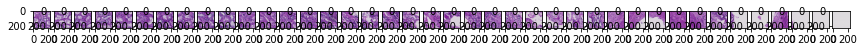

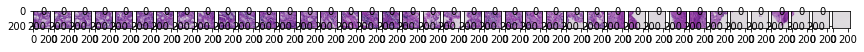

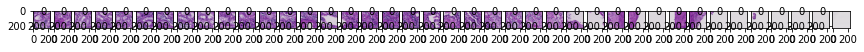

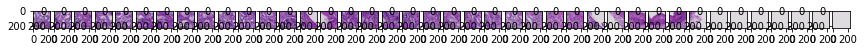

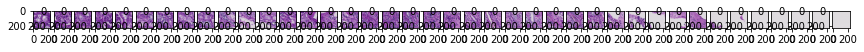

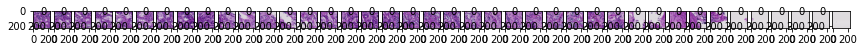

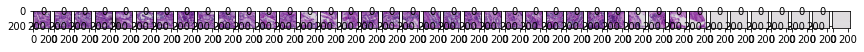

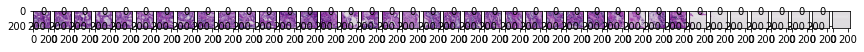

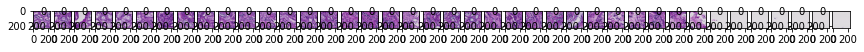

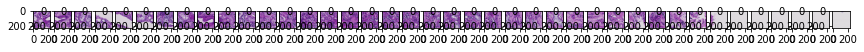

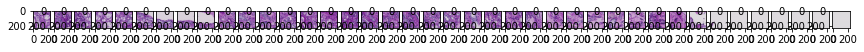

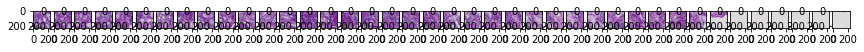

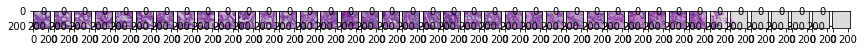

In [45]:
import matplotlib.pyplot as plt
image.shape
l1=list(range(0,image.shape[0],224))
l2=list(range(0,image.shape[1],224))


l1=list(range(7000,10000,224))
l2=list(range(2000,11000,224))
plt.figure(figsize=(15,15))
# plt.tight_layout()

#fig, axes = plt.subplots(nrows=3, ncols=5)
#plt.subplots(nrows=3, ncols=5)
#fig.tight_layout()
#plt.subplot(1, 2, 1)
c=1
np.random.seed(1) 
sy=np.random.randint(100,1510)
sx=np.random.randint(100,1510)
shifty=sy#500
shiftx=sx#500
r=len(l2)
mask_per=[]
for i in range(len(l1)-1):
  for j in range(len(l2)-1):
    #print(i,"\t",j)
    imx=image[l1[i]+shifty:l1[i+1]+shifty, l2[j]+shiftx:l2[j+1]+shiftx, :]
    mskx=mask[l1[i]+shifty:l1[i+1]+shifty, l2[j]+shiftx:l2[j+1]+shiftx ]
    if np.sum(mskx==1)>0:
      mask_per.append(np.sum(mskx==1)/(mskx.shape[0]*mskx.shape[1]))
    else:
      mask_per.append(0)
     
    
    if c==r:
      c=1
      plt.figure(figsize=(15,15))
    #plt.subplot(1, ((len(l1)-1)*(len(l2)-1)), c)
    plt.subplot(1, r, c)
    #plt.figure(figsize=(3,3))
    plt.imshow(imx)
   # plt.imshow(mskx, cmap='jet', alpha=0.7515)
    

    c+=1

In [29]:
# np.sum(mskx==1)
# np.sum(mskx==1))/(mskx.shape[0]*mskx.shape[1]))
mask_per
#(len(l1)-1)*(len(l2)-1)

NameError: ignored

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=4, ncols=4)
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"

plt.show()

In [ ]:
1e6/224**2
l2

[2000,
 2224,
 2448,
 2672,
 2896,
 3120,
 3344,
 3568,
 3792,
 4016,
 4240,
 4464,
 4688,
 4912,
 5136,
 5360,
 5584,
 5808,
 6032,
 6256,
 6480,
 6704,
 6928,
 7152,
 7376,
 7600,
 7824,
 8048,
 8272,
 8496,
 8720,
 8944,
 9168,
 9392,
 9616,
 9840,
 10064,
 10288,
 10512,
 10736,
 10960]

#### calculate percentage of mask



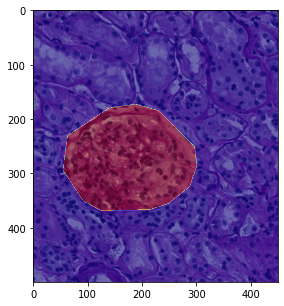

In [ ]:
plt.figure(figsize=(10,5))
d1=np.array(range(7000,10500,1))
d2=np.array(range(1200,1700,1))
plt.imshow(image[10000:10500, 5150:5600, :])
plt.imshow(mask[10000:10500, 5150:5600], cmap='jet', alpha=0.515)

m_1=mask[10000:10500, 5150:5600]
t_1=image[10000:10500, 5150:5600, :]

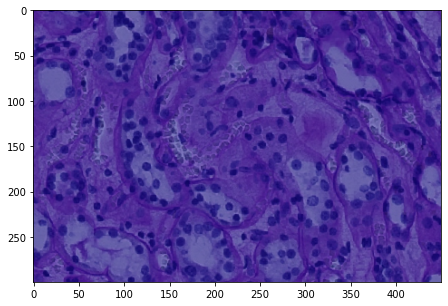

In [ ]:
plt.figure(figsize=(10,5))
d1=np.array(range(7000,10500,1))
d2=np.array(range(1200,1700,1))
plt.imshow(image[10700:11000, 7150:7600, :])
plt.imshow(mask[10700:11000, 7150:7600], cmap='jet', alpha=0.515)

m_2=mask[10700:11000, 7150:7600]
t_2=image[10700:11000, 7150:7600, :]

In [ ]:
np.unique(m_1) 
np.where(m_1==1)

np.sum(m_1==0)


m_1.shape
np.sum(m_1==1)/(m_1.shape[0]*m_1.shape[1])


0.16395555555555555

In [ ]:
print(mask_per)
len(mask_per)
np.sum(np.array(mask_per)>0)

[0, 0, 0, 0, 0, 0, 0.2512954400510204, 0.13347018494897958, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.08785076530612244, 0, 0, 0, 0, 0, 0.2656847895408163, 0.2214405293367347, 0.12147241709183673, 0.35060586734693877, 0, 0, 0.2803531568877551, 0.02170360331632653, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.11188616071428571, 0, 0, 0, 0, 0, 0, 0, 0.02014907525510204, 0.13879145408163265, 0.36136798469387754, 0.0027104591836734694, 0.2545639349489796, 0.025849011479591837, 0, 0.2056560905612245, 0.00972576530612245, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.00013950892857142856, 0.31937579719387754, 0.006297831632653061, 0.4728156887755102, 0.1924625318877551, 0, 0.7345344387755102, 0.2609813456632653, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.6493144132653061, 0.08902662627551021, 0.47945232780612246, 0.35752

70

##### it appears that around 70/520 of the tiles include glom. i.e., the data is severely unbalanced
##### next, we'll balance the dataset


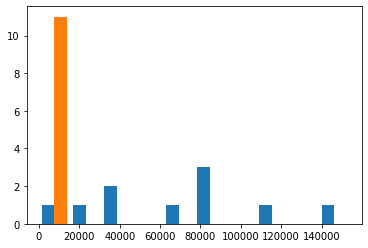

In [ ]:
 np.histogram(t_1)
 plt.hist(np.histogram(t_1))
 
def show_tile_dist(tile):
    fig, ax = plt.subplots(1,2,figsize=(20,3))
    #ax[0].set_title("Tile ID = {} Xpos = {} Ypos = {}".format(img_mtd['tile_id'], img_mtd['tile_col_pos'],img_mtd['tile_row_pos']))
    ax[0].imshow(tile)
    ax[1].set_title("Pixelarray distribution");
    sns.distplot(tile.flatten(), ax=ax[1]);

In [1]:
show_tile_dist(t_1)
show_tile_dist(t_2)
# so far we have the following data:
# - tile
# - hist (seems useless; unless doing low/high pass)
# - percentage of glom.
# need to find:
# - howto read the np.arrays as input to the network; first, we'll try out inception network.
# - remember we have two types of inputs as independent vars: an image and a float; the dependent variable will be 1/0 (contains glom/doesn't contain)

NameError: ignored